In [35]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile

import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from sklearn.metrics import brier_score_loss, roc_auc_score
from socceraction.spadl.wyscout import convert_to_spadl
from socceraction.vaep.formula import value
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [5]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

In [6]:
data_files = {
    'events': 'https://ndownloader.figshare.com/files/14464685',  # ZIP file containing one JSON file for each competition
    'matches': 'https://ndownloader.figshare.com/files/14464622',  # ZIP file containing one JSON file for each competition
    'players': 'https://ndownloader.figshare.com/files/15073721',  # JSON file
    'teams': 'https://ndownloader.figshare.com/files/15073697'  # JSON file
}

In [7]:
for url in tqdm(data_files.values()):
    url_s3 = urlopen(url).geturl()
    path = Path(urlparse(url_s3).path)
    file_name = path.name
    file_local, _ = urlretrieve(url_s3, file_name)
    if is_zipfile(file_local):
        with ZipFile(file_local) as zip_file:
            zip_file.extractall()

  0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
import json


In [9]:
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

In [10]:
json_teams = read_json_file('teams.json')
df_teams = pd.read_json(json_teams)

In [11]:
df_teams.head(10)

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
5,Troyes,Troyes,3795,Espérance Sportive Troyes Aube Champagne,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
6,Getafe (Madrid),Getafe,698,Getafe Club de Fútbol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
7,Mönchengladbach,Borussia M'gladbach,2454,Borussia VfL Mönchengladbach,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
8,"Huddersfield, West Yorkshire",Huddersfield Town,1673,Huddersfield Town FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
9,Bilbao,Athletic Club,678,Athletic Club Bilbao,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [12]:
df_teams.to_hdf('wyscout.h5', key='teams', mode='w')

In [13]:
json_players = read_json_file('players.json')
df_players = pd.read_json(json_players)

In [14]:
df_players.head(10)

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konaté,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konaté,null
5,"{'name': 'Netherlands', 'id': '528', 'alpha3co...",83,Jasper,,Cillessen,676,1989-04-22,185,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Netherlands', 'id': '528', 'alpha3co...",33,right,J. Cillessen,664
6,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",91,Toby,,Alderweireld,1624,1989-03-02,187,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Belgium', 'id': '56', 'alpha3code': ...",36,right,T. Alderweireld,5629
7,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",88,Jan,,Vertonghen,1624,1987-04-24,189,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Belgium', 'id': '56', 'alpha3code': ...",48,left,J. Vertonghen,5629
8,"{'name': 'France', 'id': '250', 'alpha3code': ...",74,Alexander,,Djiku,3783,1994-08-09,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",229427,right,A. Djiku,null
9,"{'name': 'Denmark', 'id': '208', 'alpha3code':...",76,Christian,,Dannemann Eriksen,1624,1992-02-14,180,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Denmark', 'id': '208', 'alpha3code':...",54,right,C. Eriksen,7712


In [15]:
df_players.to_hdf('wyscout.h5', key='players', mode='a')

In [16]:
competitions = [
    'England',
#     'France',
#     'Germany',
#     'Italy',
#    'Spain',
#   'European Championship',
#   'World Cup'
]

In [17]:
dfs_matches = []
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    json_matches = read_json_file(file_matches)
    df_matches = pd.read_json(json_matches)
    dfs_matches.append(df_matches)
df_matches = pd.concat(dfs_matches)

In [18]:
df_matches.head(10)

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",Regular,364
1,Played,4405654,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",181150,2018-05-13 14:00:00,1628,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381851, 'role': 'referee'}, {'r...",Regular,364
2,Played,4405654,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2018-05-13 14:00:00,1609,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364
3,Played,4405654,38,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",181150,2018-05-13 14:00:00,1612,Anfield,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385704, 'role': 'referee'}, {'r...",Regular,364
4,Played,4405654,38,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",181150,2018-05-13 14:00:00,1611,Old Trafford,2500093,"Manchester United - Watford, 1 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381853, 'role': 'referee'}, {'r...",Regular,364
5,Played,4405654,38,"{'1613': {'scoreET': 0, 'coachId': 210700, 'si...",181150,2018-05-13 14:00:00,1613,St. James' Park,2500094,"Newcastle United - Chelsea, 3 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384888, 'role': 'referee'}, {'r...",Regular,364
6,Played,4405654,38,"{'1625': {'scoreET': 0, 'coachId': 267136, 'si...",181150,2018-05-13 14:00:00,1625,St. Mary's Stadium,2500095,"Southampton - Manchester City, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385911, 'role': 'referee'}, {'r...",Regular,364
7,Played,4405654,38,"{'10531': {'scoreET': 0, 'coachId': 32573, 'si...",181150,2018-05-13 14:00:00,1639,Liberty Stadium,2500096,"Swansea City - Stoke City, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 378952, 'role': 'referee'}, {'r...",Regular,364
8,Played,4405654,38,"{'1631': {'scoreET': 0, 'coachId': 209010, 'si...",181150,2018-05-13 14:00:00,1624,Wembley Stadium,2500097,"Tottenham Hotspur - Leicester City, 5 - 4","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 378951, 'role': 'referee'}, {'r...",Regular,364
9,Played,4405654,38,"{'1623': {'scoreET': 0, 'coachId': 8541, 'side...",181150,2018-05-13 14:00:00,1633,London Stadium,2500098,"West Ham United - Everton, 3 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 408156, 'role': 'referee'}, {'r...",Regular,364


In [19]:
df_matches.to_hdf('wyscout.h5', key='matches', mode='a')

In [20]:
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_events = f'events_{competition_name}.json'
    json_events = read_json_file(file_events)
    df_events = pd.read_json(json_events)
    df_events_matches = df_events.groupby('matchId', as_index=False)
    for match_id, df_events_match in df_events_matches:
        df_events_match.to_hdf('wyscout.h5', key=f'events/match_{match_id}', mode='a')

In [21]:
convert_to_spadl('wyscout.h5', 'spadl.h5')

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


100%|██████████████████████████████████████████████████████████████████████████████| 380/380 [00:32<00:00, 11.80game/s]


...Converting events to actions


100%|██████████████████████████████████████████████████████████████████████████████| 380/380 [03:41<00:00,  1.72game/s]


In [22]:
df_games = pd.read_hdf('spadl.h5', key='games')
df_actiontypes = pd.read_hdf('spadl.h5', key='actiontypes')
df_bodyparts = pd.read_hdf('spadl.h5', key='bodyparts')
df_results = pd.read_hdf('spadl.h5', key='results')

In [23]:
nb_prev_actions = 3

In [24]:
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

In [25]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .reset_index(drop=True)
    )
    
    dfs_gamestates = features.gamestates(df_actions, nb_prev_actions=nb_prev_actions)
    dfs_gamestates = features.play_left_to_right(dfs_gamestates, game['home_team_id'])
    
    df_features = pd.concat([function(dfs_gamestates) for function in functions_features], axis=1)
    df_features.to_hdf('features.h5', key=f'game_{game_id}')

  0%|          | 0/380 [00:00<?, ?it/s]

In [26]:
functions_labels = [
    labels.scores,
    labels.concedes
]

In [27]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .reset_index(drop=True)
    )
    
    df_labels = pd.concat([function(df_actions) for function in functions_labels], axis=1)
    df_labels.to_hdf('labels.h5', key=f'game_{game_id}')

  0%|          | 0/380 [00:00<?, ?it/s]

In [28]:
columns_features = features.feature_column_names(functions_features, nb_prev_actions=nb_prev_actions)

In [29]:
dfs_features = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    dfs_features.append(df_features[columns_features])
df_features = pd.concat(dfs_features).reset_index(drop=True)

  0%|          | 0/380 [00:00<?, ?it/s]

In [30]:
df_features.head(10)

,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,type_take_on_a0,type_foul_a0,type_tackle_a0,...,end_dist_to_goal_a0,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,...,63.091679,0.053916,63.091679,0.053916,63.091679,0.053916,True,True,0.000000,0.000000
1,True,False,False,False,False,False,False,False,False,False,...,68.328929,0.355773,63.091679,0.053916,63.091679,0.053916,True,True,1.997756,1.997756
2,True,False,False,False,False,False,False,False,False,False,...,73.715416,0.185556,68.328929,0.355773,63.091679,0.053916,True,True,0.771744,2.769500
3,True,False,False,False,False,False,False,False,False,False,...,38.707772,0.396818,73.715416,0.185556,68.328929,0.355773,True,True,2.174464,2.946208
4,True,False,False,False,False,False,False,False,False,False,...,37.425928,0.620467,38.707772,0.396818,73.715416,0.185556,True,True,3.907382,6.081846
5,True,False,False,False,False,False,False,False,False,False,...,30.729141,1.258205,37.425928,0.620467,38.707772,0.396818,True,True,3.758730,7.666112
6,False,True,False,False,False,False,False,False,False,False,...,8.400000,0.000000,30.729141,1.258205,37.425928,0.620467,True,True,2.210584,5.969314
7,False,False,False,False,False,False,False,False,False,False,...,106.094842,0.246030,96.600000,0.000000,99.923872,0.296969,False,False,1.756122,3.966706
8,False,True,False,False,False,False,False,False,False,False,...,25.925192,1.489705,25.925192,1.489705,8.400000,0.000000,False,True,2.095783,3.851905
9,False,False,False,False,False,False,False,False,False,False,...,89.647658,0.388999,106.094842,0.246030,106.094842,0.246030,False,True,3.034782,5.130565


In [31]:
columns_labels = [
    'scores',
    'concedes'
]

In [32]:
dfs_labels = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    dfs_labels.append(df_labels[columns_labels])
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

  0%|          | 0/380 [00:00<?, ?it/s]

In [33]:
df_labels.head(10)

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
5,False,False
6,False,False
7,False,False
8,False,False
9,False,False


In [38]:
%%time
models = {}
for column_labels in columns_labels:
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False
    )
    model.fit(df_features, df_labels[column_labels])
    models[column_labels] = model

CPU times: total: 26min 55s
Wall time: 7min 8s


In [39]:
dfs_predictions = {}
for column_labels in columns_labels:
    model = models[column_labels]
    probabilities = model.predict_proba(df_features)
    predictions = probabilities[:, 1]
    dfs_predictions[column_labels] = pd.Series(predictions)
df_predictions = pd.concat(dfs_predictions, axis=1)

In [40]:
df_predictions.head(10)

,scores,concedes
0,0.001565,0.000342
1,0.002807,0.001644
2,0.002975,0.000755
3,0.009620,0.001625
4,0.017388,0.000717
5,0.010581,0.007906
6,0.005190,0.001946
7,0.003626,0.019720
8,0.002979,0.001047
9,0.001261,0.011917


In [41]:
dfs_game_ids = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    dfs_game_ids.append(df_actions['game_id'])
df_game_ids = pd.concat(dfs_game_ids, axis=0).astype('int').reset_index(drop=True)

  0%|          | 0/380 [00:00<?, ?it/s]

In [42]:
df_predictions = pd.concat([df_predictions, df_game_ids], axis=1)

In [43]:
df_predictions.head(10)

,scores,concedes,game_id
0,0.001565,0.000342,2500089
1,0.002807,0.001644,2500089
2,0.002975,0.000755,2500089
3,0.009620,0.001625,2500089
4,0.017388,0.000717,2500089
5,0.010581,0.007906,2500089
6,0.005190,0.001946,2500089
7,0.003626,0.019720,2500089
8,0.002979,0.001047,2500089
9,0.001261,0.011917,2500089


In [44]:
df_predictions_per_game = df_predictions.groupby('game_id')

In [45]:
for game_id, df_predictions in tqdm(df_predictions_per_game):
    df_predictions = df_predictions.reset_index(drop=True)
    df_predictions[columns_labels].to_hdf('predictions.h5', key=f'game_{game_id}')

  0%|          | 0/380 [00:00<?, ?it/s]

In [46]:
df_players = pd.read_hdf('spadl.h5', key='players')
df_teams = pd.read_hdf('spadl.h5', key='teams')

In [47]:
dfs_values = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .merge(df_players, how='left')
        .merge(df_teams, how='left')
        .reset_index(drop=True)
    )
    
    df_predictions = pd.read_hdf('predictions.h5', key=f'game_{game_id}')
    df_values = value(df_actions, df_predictions['scores'], df_predictions['concedes'])
    
    df_all = pd.concat([df_actions, df_predictions, df_values], axis=1)
    dfs_values.append(df_all)

  0%|          | 0/380 [00:00<?, ?it/s]

In [48]:
df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [49]:
df_values[
    ['short_name','team_name' , 'scores', 'concedes', 'offensive_value', 'defensive_value', 'vaep_value']
].head(10)

,short_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
0,A. Lacazette,Arsenal FC,0.000207,0.000070,0.000000,-0.000000,0.000000
1,R. Holding,Arsenal FC,0.005683,0.000795,0.005476,-0.000725,0.004751
2,M. Özil,Arsenal FC,0.007332,0.000862,0.001649,-0.000068,0.001582
3,Mohamed Elneny,Arsenal FC,0.004931,0.001380,-0.002401,-0.000518,-0.002919
4,Bellerín,Arsenal FC,0.009885,0.003907,0.004954,-0.002527,0.002427
5,M. Özil,Arsenal FC,0.008336,0.003977,-0.001549,-0.000070,-0.001619
6,H. Maguire,Leicester City FC,0.004430,0.006996,0.000453,0.001340,0.001793
7,Bellerín,Arsenal FC,0.008783,0.003025,0.001787,0.001405,0.003192
8,Bellerín,Arsenal FC,0.008157,0.002096,-0.000626,0.000929,0.000303
9,G. Xhaka,Arsenal FC,0.006883,0.001196,-0.001274,0.000900,-0.000374


In [50]:
df_values["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    df_values[["player_id","team_name", "vaep_value", "offensive_value", "defensive_value","count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)

In [51]:
# Add player names
playersR = playersR.merge(df_players[["player_id", "short_name"]], how="left")
playersR["player_name"] = playersR[["short_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
392,120353.0,Mohamed Salah,23.858101,24.823477,-0.965375,1568
325,38021.0,K. De Bruyne,19.006954,19.484728,-0.477775,3528
313,26150.0,R. Mahrez,18.335896,18.530178,-0.194284,2022
4,54.0,C. Eriksen,16.920042,16.269474,0.650568,2959
300,25707.0,E. Hazard,16.024981,16.583902,-0.558923,1974
185,8717.0,H. Kane,14.096480,15.502703,-1.406222,1153
140,8317.0,David Silva,12.788353,13.432590,-0.644237,2925
266,15808.0,Roberto Firmino,11.886950,11.845620,0.041329,1633
333,49872.0,X. Shaqiri,11.708034,12.759151,-1.051118,1722
27,3319.0,M. Özil,11.278624,13.102194,-1.823570,2278


In [52]:
pg = pd.read_hdf('spadl.h5', "player_games")
pg = pg[pg.game_id.isin(df_games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending = False)

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
141,8324.0,Y. Touré,2.426949,2.467705,-0.040757,466,260.985572,0.836925,0.850980,-0.014055
48,3802.0,Philippe Coutinho,9.460539,10.110363,-0.649824,1014,1134.538547,0.750480,0.802029,-0.051549
391,120353.0,Mohamed Salah,23.858101,24.823477,-0.965375,1568,2996.529579,0.716572,0.745567,-0.028995
299,25707.0,E. Hazard,16.024981,16.583902,-0.558923,1974,2505.438518,0.575647,0.595725,-0.020078
312,26150.0,R. Mahrez,18.335896,18.530178,-0.194284,2022,3063.065477,0.538751,0.544460,-0.005709
...,...,...,...,...,...,...,...,...,...,...
326,38093.0,M. Batshuayi,-0.527188,-0.276889,-0.250299,137,386.672156,-0.122706,-0.064447,-0.058258
335,55224.0,A. Sørloth,-0.614286,-0.591318,-0.022968,144,374.747511,-0.147528,-0.142012,-0.005516
41,3551.0,W. Caballero,-0.472424,0.334823,-0.807247,105,283.809493,-0.149812,0.106177,-0.255989
54,5911.0,Sandro,-0.760288,-0.598350,-0.161938,119,292.505208,-0.233931,-0.184104,-0.049826


In [53]:
stats.to_csv('ranking.csv', index=False)

In [54]:
playersR.to_csv('ranking!.csv', index=False)

In [55]:
print(df_values['team_name'].unique())

['Arsenal FC' 'Leicester City FC' 'Manchester City FC'
 'Brighton & Hove Albion FC' 'Burnley FC' 'Chelsea FC' 'Crystal Palace FC'
 'Huddersfield Town FC' 'Everton FC' 'Stoke City FC'
 'Manchester United FC' 'West Ham United FC' 'Newcastle United FC'
 'Tottenham Hotspur FC' 'Swansea City AFC' 'Southampton FC' 'Watford FC'
 'Liverpool FC' 'West Bromwich Albion FC' 'AFC Bournemouth']


In [56]:
WB_team =df_values[(df_values["team_name"]== "Chelsea FC" ) | (df_values["team_name"]== "Arsenal FC" ) | (df_values["team_name"]== "West Ham United FC" )| (df_values["team_name"]== "Swansea City AFC" ) ]

In [57]:
WB_team

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,...,last_name,birth_date,short_team_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value,count
0,2499719.0,1.0,2.758649,1609.0,25413.0,51.45,34.68,32.55,14.96,0,...,Lacazette,1991-05-28,Arsenal,Arsenal FC,0.000207,0.000070,0.000000,-0.000000,0.000000,1
1,2499719.0,1.0,4.946850,1609.0,370224.0,32.55,14.96,53.55,17.00,0,...,Holding,1995-09-20,Arsenal,Arsenal FC,0.005683,0.000795,0.005476,-0.000725,0.004751,1
2,2499719.0,1.0,6.542188,1609.0,3319.0,53.55,17.00,36.75,19.72,1,...,Özil,1988-10-15,Arsenal,Arsenal FC,0.007332,0.000862,0.001649,-0.000068,0.001582,1
3,2499719.0,1.0,8.143395,1609.0,120339.0,36.75,19.72,43.05,3.40,1,...,Elsayed Elneny,1992-07-11,Arsenal,Arsenal FC,0.004931,0.001380,-0.002401,-0.000518,-0.002919,1
4,2499719.0,1.0,10.302366,1609.0,167145.0,43.05,3.40,75.60,8.16,0,...,Bellerín Moruno,1995-03-19,Arsenal,Arsenal FC,0.009885,0.003907,0.004954,-0.002527,0.002427,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483659,2500098.0,2.0,2783.137836,1633.0,8561.0,61.95,20.40,55.65,7.48,0,...,Noble,1987-05-08,West Ham United,West Ham United FC,0.017734,0.000508,0.006533,0.000012,0.006545,1
483660,2500098.0,2.0,2785.702032,1633.0,20620.0,55.65,7.48,103.95,19.04,0,...,Mba Obiang Avomo,1992-03-27,West Ham United,West Ham United FC,0.028295,0.001165,0.010561,-0.000657,0.009905,1
483661,2500098.0,2.0,2789.232666,1633.0,14703.0,103.95,19.04,103.95,19.04,0,...,Arnautović,1989-04-19,West Ham United,West Ham United FC,0.020567,0.001734,-0.007728,-0.000569,-0.008296,1
483663,2500098.0,2.0,2829.821084,1633.0,70965.0,105.00,0.00,92.40,36.04,0,...,Naval da Costa Eduardo,1993-01-19,West Ham United,West Ham United FC,0.061012,0.000254,0.014512,-0.000254,0.014257,1


In [58]:
print(WB_team['short_name'].unique().tolist())

['A. Lacazette', 'R. Holding', 'M. Özil', 'Mohamed Elneny', 'Bellerín', 'G. Xhaka', 'S. Kolašinac', 'Nacho Monreal', 'P. Čech', 'D. Welbeck', nan, 'A. Oxlade-Chamberlain', 'A. Ramsey', 'O. Giroud', 'T. Walcott', 'A. Rüdiger', 'Fàbregas', 'Azpilicueta', 'T. Courtois', 'Marcos Alonso', 'Willian', 'David Luiz', 'G. Cahill', 'N. Kanté', 'M. Batshuayi', 'J. Boga', 'A. Christensen', 'Álvaro Morata', 'Pedro Obiang', 'A. Ogbonna', 'M. Noble', 'E. Fernandes', 'A. Ayew', 'P. Zabaleta', 'A. Masuaku', 'J. Hart', 'J. Hernández', 'M. Arnautović', 'W. Reid', 'D. Sakho', 'D. Rice', 'A. Cresswell', 'W. Routledge', 'L. Britton', 'A. Mawson', 'F. Fernández', 'K. Naughton', 'Ł. Fabiański', 'J. Ayew', 'M. Olsson', 'L. Fer', 'T. Carroll', 'T. Abraham', 'K. Bartley', 'J. Fulton', 'O. McBurnie', 'S. Mustafi', 'A. Iwobi', 'Roque Mesa', 'L. Narsingh', 'V. Moses', 'T. Bakayoko', 'Pedro', 'C. Kouyaté', 'M. Antonio', 'João Mário', 'J. Hugill', 'J. Cullen', 'S. Clucas', 'M. van der Hoorn', 'Àngel Rangel', 'A. Sánch

In [59]:
WB = stats[(stats["player_name"]== "Bellerín" ) |(stats["player_name"]== "S. Kolašinac" ) |(stats["player_name"]== "A. Maitland-Niles" ) |(stats["player_name"]== "V. Moses" ) | (stats["player_name"]== "Marcos Alonso" ) | (stats["player_name"]== "Emerson" )| (stats["player_name"]== "D. Zappacosta" )|  (stats["player_name"]== "M. Olsson" ) | (stats["player_name"]== "K. Naughton" ) | (stats["player_name"]== "Àngel Rangel" ) | (stats["player_name"]== "C. Roberts" ) | (stats["player_name"]== "A. Cresswell" ) | (stats["player_name"]== "A. Masuaku" ) | (stats["player_name"]== "P. Evra" ) | (stats["player_name"]== "P. Zabaleta" ) | (stats["player_name"]== "S. Byram" ) ] 
WB

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
75,7915.0,P. Evra,0.865485,0.324754,0.540731,139,239.171364,0.325681,0.122205,0.203477
103,8032.0,Marcos Alonso,6.692132,6.213044,0.479088,2114,2973.092359,0.202581,0.188078,0.014503
119,8192.0,M. Olsson,1.201434,3.786267,-2.584833,1991,3275.735688,0.033009,0.104027,-0.071018
137,8313.0,P. Zabaleta,4.384175,4.311275,0.072899,2015,3435.489529,0.114853,0.112943,0.001910
143,8336.0,K. Naughton,3.320565,5.078607,-1.758042,2596,3154.820340,0.094728,0.144881,-0.050153
173,8582.0,A. Cresswell,4.342694,5.975092,-1.632398,2062,3203.680895,0.121998,0.167856,-0.045858
178,8625.0,V. Moses,5.485507,5.596414,-0.110906,1466,2182.161945,0.226242,0.230816,-0.004574
254,14869.0,S. Kolašinac,6.655830,6.138340,0.517490,1772,2233.897372,0.268152,0.247303,0.020849
285,22889.0,D. Zappacosta,1.334712,1.523474,-0.188762,866,1153.394539,0.104148,0.118877,-0.014729
314,26499.0,A. Masuaku,3.904981,4.852137,-0.947156,1313,1967.838246,0.178596,0.221915,-0.043319


In [64]:
FB_team =df_values[(df_values["team_name"]== "Leicester City FC" ) |(df_values["team_name"]== "Manchester City FC" ) |(df_values["team_name"]== "Brighton & Hove Albion FC" ) |(df_values["team_name"]== "Burnley FC" ) |(df_values["team_name"]== "Crystal Palace FC" ) |(df_values["team_name"]== "Huddersfield Town FC" ) |(df_values["team_name"]== "Everton FC" ) |(df_values["team_name"]== "Stoke City FC" ) |(df_values["team_name"]== "Manchester United FC" ) |(df_values["team_name"]== "Newcastle United FC" ) |(df_values["team_name"]== "Tottenham Hotspur FC" ) | (df_values["team_name"]== "Southampton FC" ) | (df_values["team_name"]== "Watford FC" )| (df_values["team_name"]== "Liverpool FC" ) | (df_values["team_name"]== "West Bromwich Albion FC" )|(df_values["team_name"]== "AFC Bournemouth" ) ]
FB_team

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,...,last_name,birth_date,short_team_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value,count
6,2499719.0,1.0,13.961228,1631.0,8653.0,80.85,17.00,64.05,10.20,1,...,Maguire,1993-03-05,Leicester City,Leicester City FC,0.004430,0.006996,0.000453,0.001340,0.001793,1
13,2499719.0,1.0,25.904249,1631.0,8653.0,79.80,21.08,60.90,10.20,1,...,Maguire,1993-03-05,Leicester City,Leicester City FC,0.004870,0.002583,-0.005028,0.005644,0.000616,1
14,2499719.0,1.0,27.527696,1631.0,8013.0,60.90,10.20,74.55,17.68,1,...,Albrighton,1989-11-18,Leicester City,Leicester City FC,0.004426,0.006204,-0.000444,-0.003621,-0.004065,1
15,2499719.0,1.0,29.980898,1631.0,265366.0,74.55,17.68,66.15,5.44,0,...,Ndidi,1996-12-16,Leicester City,Leicester City FC,0.003485,0.002170,-0.000941,0.004034,0.003093,1
16,2499719.0,1.0,31.163870,1631.0,8013.0,66.15,5.44,80.85,3.40,0,...,Albrighton,1989-11-18,Leicester City,Leicester City FC,0.002964,0.008051,-0.000521,-0.005882,-0.006403,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483631,2500098.0,2.0,2682.271344,1623.0,56.0,35.70,26.52,38.85,42.84,0,...,Klaassen,1993-02-21,Everton,Everton FC,0.014829,0.003762,-0.001571,0.001784,0.000213,1
483632,2500098.0,2.0,2683.754085,1623.0,25706.0,38.85,42.84,28.35,37.40,0,...,Gueye,1989-09-26,Everton,Everton FC,0.031003,0.002513,0.016174,0.001249,0.017424,1
483633,2500098.0,2.0,2684.747496,1623.0,145692.0,28.35,37.40,32.55,32.64,0,...,Niasse,1990-04-18,Everton,Everton FC,0.025658,0.002221,-0.005346,0.000292,-0.005054,1
483657,2500098.0,2.0,2771.985870,1623.0,56.0,61.95,11.56,61.95,11.56,0,...,Klaassen,1993-02-21,Everton,Everton FC,0.000353,0.004291,-0.000148,0.000113,-0.000036,1


In [85]:
print(WB_team['short_name'].unique().tolist())

['A. Lacazette', 'R. Holding', 'M. Özil', 'Mohamed Elneny', 'Bellerín', 'G. Xhaka', 'S. Kolašinac', 'Nacho Monreal', 'P. Čech', 'D. Welbeck', nan, 'A. Oxlade-Chamberlain', 'A. Ramsey', 'O. Giroud', 'T. Walcott', 'A. Rüdiger', 'Fàbregas', 'Azpilicueta', 'T. Courtois', 'Marcos Alonso', 'Willian', 'David Luiz', 'G. Cahill', 'N. Kanté', 'M. Batshuayi', 'J. Boga', 'A. Christensen', 'Álvaro Morata', 'Pedro Obiang', 'A. Ogbonna', 'M. Noble', 'E. Fernandes', 'A. Ayew', 'P. Zabaleta', 'A. Masuaku', 'J. Hart', 'J. Hernández', 'M. Arnautović', 'W. Reid', 'D. Sakho', 'D. Rice', 'A. Cresswell', 'W. Routledge', 'L. Britton', 'A. Mawson', 'F. Fernández', 'K. Naughton', 'Ł. Fabiański', 'J. Ayew', 'M. Olsson', 'L. Fer', 'T. Carroll', 'T. Abraham', 'K. Bartley', 'J. Fulton', 'O. McBurnie', 'S. Mustafi', 'A. Iwobi', 'Roque Mesa', 'L. Narsingh', 'V. Moses', 'T. Bakayoko', 'Pedro', 'C. Kouyaté', 'M. Antonio', 'João Mário', 'J. Hugill', 'J. Cullen', 'S. Clucas', 'M. van der Hoorn', 'Àngel Rangel', 'A. Sánch

In [83]:
FB = stats[(stats["player_name"]== "B. Chilwell" ) |(stats["player_name"]== "C. Fuchs" ) |(stats["player_name"]== "D. Simpson" ) |(stats["player_name"]== "D. Amartey" ) | (stats["player_name"]== "O. Zinchenko" ) | (stats["player_name"]== "B. Mendy" )| (stats["player_name"]== "F. Delph" )|  (stats["player_name"]== "K. Walker" ) | (stats["player_name"]== "Danilo" ) | (stats["player_name"]== "M. Suttner" ) | (stats["player_name"]== "G. Bong" ) | (stats["player_name"]== "E. Schelotto" ) | (stats["player_name"]== "Bruno Saltor" ) | (stats["player_name"]== "M. Lowton" ) | (stats["player_name"]== "P. Bardsley" ) | (stats["player_name"]== "C. Taylor" ) | (stats["player_name"]== "P. Bardsley" ) |(stats["player_name"]== "S. Ward" ) |(stats["player_name"]== "J. Ward" ) |(stats["player_name"]== "P. van Aanholt" ) |(stats["player_name"]== "M. Kelly" ) |(stats["player_name"]== "P. Souaré" ) |(stats["player_name"]== "S. Malone" ) |(stats["player_name"]== "F. Hadergjonaj" ) |(stats["player_name"]== "C. Löwe" ) |(stats["player_name"]== "S. Coleman" )| (stats["player_name"]== "L. Baines" ) |(stats["player_name"]== "J. Kenny" ) |(stats["player_name"]== "Cuco Martina" ) |(stats["player_name"]== "G. Johnson" ) |(stats["player_name"]== "M. Bauer" ) |(stats["player_name"]== "E. Pieters" )  |(stats["player_name"]== "L. Shaw" ) |(stats["player_name"]== "A. Valencia" ) |(stats["player_name"]== "A. Young" ) |(stats["player_name"]== "P. Dummett" ) |(stats["player_name"]== "D. Yedlin" ) |(stats["player_name"]== "Javi Manquillo" ) |(stats["player_name"]== "K. Trippier" ) |(stats["player_name"]== "S. Aurier" ) |(stats["player_name"]== "B. Davies" ) |(stats["player_name"]== "Cédric Soares" ) |(stats["player_name"]== "R. Bertrand" ) |(stats["player_name"]== "J. Holebas" ) |(stats["player_name"]== "D. Janmaat" ) |(stats["player_name"]== "Kiko Femenía" ) |(stats["player_name"]== "M. Zeegelaar" ) |(stats["player_name"]== "A. Nyom" ) |(stats["player_name"]== "C. Dawson" ) |(stats["player_name"]== "K. Gibbs" ) |(stats["player_name"]== "C. Daniels" ) |(stats["player_name"]== "S. Francis" ) |(stats["player_name"]== "A. Smith" ) |(stats["player_name"]== "T. Alexander-Arnold" ) |(stats["player_name"]== "Alberto Moreno" ) |(stats["player_name"]== "J. Gomez" ) |(stats["player_name"]== "A. Robertson" ) ] 
FB

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
7,107.0,E. Pieters,2.706067,3.828310,-1.122243,1758,2839.106630,0.085783,0.121358,-0.035575
12,160.0,D. Janmaat,4.925679,5.568748,-0.643070,1313,1897.972796,0.233571,0.264065,-0.030494
18,340.0,Cuco Martina,4.084352,3.403604,0.680748,1399,1904.549776,0.193007,0.160838,0.032169
21,454.0,P. van Aanholt,9.483280,8.482031,1.001249,1507,2283.042259,0.373841,0.334371,0.039470
25,3278.0,Bruno Saltor,2.551308,2.606357,-0.055049,1444,2096.917262,0.109503,0.111865,-0.002363
33,3351.0,Kiko Femenía,2.437495,3.271037,-0.833542,1230,1800.394686,0.121848,0.163516,-0.041668
39,3436.0,Javi Manquillo,2.759648,2.478058,0.281590,1003,1837.262397,0.135184,0.121390,0.013794
52,4908.0,Alberto Moreno,0.410293,0.633085,-0.222792,1136,1324.047550,0.027889,0.043033,-0.015144
53,5281.0,A. Nyom,3.777544,3.726727,0.050817,1415,2432.031654,0.139792,0.137912,0.001881
56,7853.0,K. Gibbs,2.671340,3.145935,-0.474595,1784,2956.439470,0.081321,0.095769,-0.014448


In [86]:
Ax = WB["offensive_rating"]
Ay = WB["defensive_rating"]
Az = WB["vaep_rating"]

Bx = FB["offensive_rating"]
By = FB["defensive_rating"]
Bz = FB["vaep_rating"]

In [87]:
import matplotlib.pyplot as plt

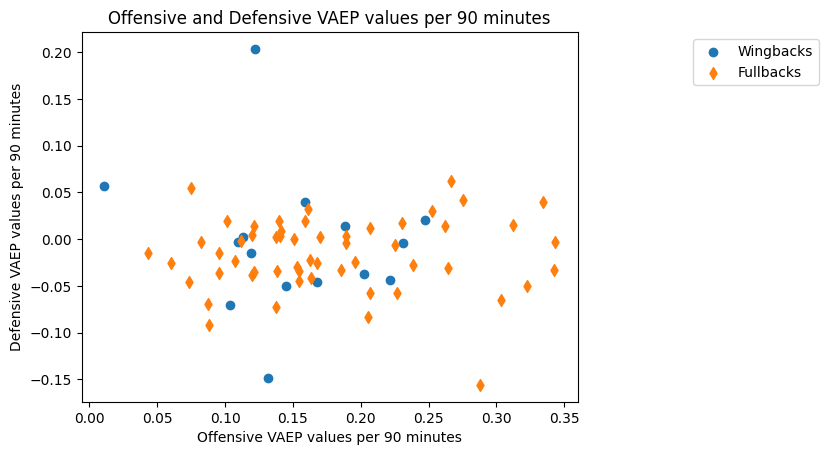

In [88]:
plt.title("Offensive and Defensive VAEP values per 90 minutes")
plt.xlabel("Offensive VAEP values per 90 minutes") 
plt.ylabel("Defensive VAEP values per 90 minutes")
plt.scatter(Ax, Ay)
plt.scatter(Bx, By, marker="d")
plt.legend(["Wingbacks" , "Fullbacks"], bbox_to_anchor = (1.5 , 1))
plt.show()

In [90]:
#Wingbacks Offensive and Defensive average 

WB_Attacking_avg = WB["offensive_rating"].mean()

WB_Defending_avg = WB["defensive_rating"].mean()

WB_Total_avg = WB_Attacking_avg - WB_Defending_avg

In [91]:
WB_Attacking_avg

0.15149349636628617

In [92]:
WB_Defending_avg

-0.005357978251850502

In [93]:
WB_Total_avg

0.15685147461813667

In [94]:
#Fullbacks Offensive and Defensive average 

FB_Attacking_avg = FB["offensive_rating"].mean()
FB_Defending_avg = FB["defensive_rating"].mean()
FB_Total_avg = FB_Attacking_avg - FB_Defending_avg

In [95]:
FB_Attacking_avg

0.1782089083265679

In [96]:
FB_Defending_avg

-0.016846968117031024

In [97]:
FB_Total_avg

0.19505587644359892

In [98]:
from prettytable import PrettyTable

# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Player position", "Total", "Offensive", "Defensive"])

# Add rows
myTable.add_row(["fullback", 0.195,0.178,-0.017])
myTable.add_row(["wingback", 0.157,0.151,-0.005])


print(myTable)

+-----------------+-------+-----------+-----------+
| Player position | Total | Offensive | Defensive |
+-----------------+-------+-----------+-----------+
|     fullback    | 0.195 |   0.178   |   -0.017  |
|     wingback    | 0.157 |   0.151   |   -0.005  |
+-----------------+-------+-----------+-----------+


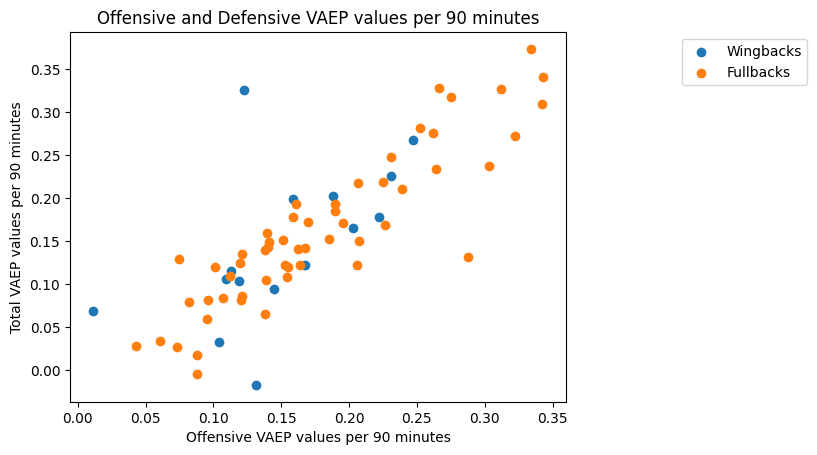

In [105]:
plt.title("Offensive and Defensive VAEP values per 90 minutes")
plt.xlabel("Offensive VAEP values per 90 minutes") 
plt.ylabel("Total VAEP values per 90 minutes")
plt.scatter(Ax, Az)
plt.scatter(Bx, Bz)
# plt.axline([-0.2, -0.18], slope=1)
xmin = Ax.min()
xmax = Ax.max()
ymin = Az.min()
ymax = Az.max()
xmargin = 0.1 * (xmax - xmin)
ymargin = 0.1 * (ymax - ymax)
margin = 0.5 * (xmargin + ymargin)
cmin = max(ymin, xmin)
cmax = min(xmax, ymax)
#plt.plot(*[[cmin - margin, cmax + margin]] * 2)
plt.legend(["Wingbacks" , "Fullbacks"], bbox_to_anchor = (1.5 , 1))
plt.show()